# GradCAM++

![method](gradcampp_method.png)

$$Y^c=\sum_k w_k^c \cdot \sum_i \sum_j A^k_{ij} \tag1$$
$$L_{ij}^c=\sum_k w_k^c A^k_{ij} \tag2$$

- CAM/GradCAM 의 기본 아이디어. 마지막 featuremap 들의 가중치 $w_k$를 구해서 weighted sum.
- 이 가중치 $w_k$ 의 계산방법은:
    - CAM: GAP 후의 마지막 linear 의 weight
    - GradCAM: $dY/dA$

Eq 1 로부터,

$$ w_k^c = \sum_i \sum_j \alpha_{ij}^{kc}\cdot \text{relu}({\delta Y^c \over \delta A^k_{ij}}) \tag5 $$

라는데.... 이게 왜 이렇게 되는지 잘 모르겠음. 수학적으로 나온게 아닌가?

- relu 는 직관적으로 받아들일 수 있음 (논문에서도 직관적으로 설명): positive partial derivatives w.r.t. each pixel
- GradCAM 은 global average 를 하지만 GradCAM++ 은 $\alpha^{kc}_{ij}$ 를 통해 weighted average

<img src="gradcampp_theories.png" alt="theories" style="width: 500px;"/>

- 메소드 & 코드가 좀 이상함.
- 그냥 한번 그대로 구현해보자.
- reference code: https://github.com/adityac94/Grad_CAM_plus_plus

In [10]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np

from cluttered_mnist import ClutteredMNISTDataset
from gradcam import GradCAM
from cam import CAM
from models import ConvLinear, ConvGAP
from utils import AverageMeter

%matplotlib inline
import matplotlib.pyplot as plt
from visualizer import Heatmap
from utils import clear_hooks, normalize

In [3]:
train_dataset = ClutteredMNISTDataset('../data/mnist_cluttered/', train=True, transform=transforms.ToTensor())
valid_dataset = ClutteredMNISTDataset('../data/mnist_cluttered/', train=False, transform=transforms.ToTensor())

processed dataset already exists; load it
processed dataset already exists; load it


In [4]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [5]:
def trainer(n_epochs, model):
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.Adam(model.parameters())

    total_loss = AverageMeter()
    total_acc = AverageMeter()

    for epoch in range(n_epochs):
        total_loss.reset()
        total_acc.reset()
        for X, y in train_loader:
            X = Variable(X).cuda()
            y = Variable(y).cuda()

            optimizer.zero_grad()
            y_ = model(X)
            loss = criterion(y_, y)
            loss.backward()
            optimizer.step()

            pred = y_.data.max(1)[1]
            acc = float(pred.eq(y.data).sum()) / train_loader.batch_size
            total_loss.update(loss.data[0])
            total_acc.update(acc)

        print("[TRAIN EPOCH {:2d}]\tLOSS {:.4f}\tACC {:.2%}".format(epoch+1, total_loss.avg, total_acc.avg))

        total_loss.reset()
        total_acc.reset()
        for X, y in valid_loader:
            X = Variable(X).cuda()
            y = Variable(y).cuda()

            y_ = model(X)
            loss = criterion(y_, y)
            
            pred = y_.data.max(1)[1]
            acc = float(pred.eq(y.data).sum()) / valid_loader.batch_size
            total_loss.update(loss.data[0])
            total_acc.update(acc)

        print("[VALID EPOCH {:2d}]\tLOSS {:.4f}\tACC {:.2%}".format(epoch+1, total_loss.avg, total_acc.avg))

In [6]:
model = ConvLinear()
model.cuda()

ConvLinear (
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear (4608 -> 256)
  (linear2): Linear (256 -> 10)
)

In [7]:
trainer(n_epochs=3, model=model)

[TRAIN EPOCH  1]	LOSS 0.8638	ACC 68.71%
[VALID EPOCH  1]	LOSS 0.1737	ACC 93.58%
[TRAIN EPOCH  2]	LOSS 0.1320	ACC 95.84%
[VALID EPOCH  2]	LOSS 0.0929	ACC 96.06%
[TRAIN EPOCH  3]	LOSS 0.0788	ACC 97.39%
[VALID EPOCH  3]	LOSS 0.0971	ACC 95.90%


In [30]:
class GradCAM_pp(object):
    def __init__(self, model, target_layer=None):
        """
        if target_layer == None as default, the last conv layer is targetted.
        """
        self.model = model

        # clear hooks
        clear_hooks(model)
        # add hooks for last featuremap & last featuremap gradients
        self.add_hooks(model, target_layer)

    def forward(self, X):
        self.last_fmap = None
        self.last_fmap_grad = None

        return self.model(X)

    def backward(self, logits, index=-1):
        """
        default index is logits.max_index()
        """
        if index == -1:
            index = logits.max(1)[1].data[0]

        self.model.zero_grad()
        logits[:, index].backward()
        
        self.exp_target_logit = torch.exp(logits[:, index])

    def activation_map(self):
        """ compute activation map """
        # last_fmap.size(): 1CKK
        # last_fmap_grad.size(): 1CKK
        assert (self.last_fmap is not None) and (self.last_fmap_grad is not None)

        # 1. calc exp_target_logit, grad1, grad2, grad3
        grad1 = self.exp_target_logit * self.last_fmap_grad.squeeze()
        grad2 = grad1 * self.last_fmap_grad.squeeze()
        grad3 = grad2 * self.last_fmap_grad.squeeze()
        
        # 2. alpha
        A = self.last_fmap.squeeze() # CKK
        n_channels = A.size(0)
        A = A.view(n_channels, -1).sum(1) # C
        A = A.view(-1, 1, 1) # C11
        
        eps = 1e-8 # for numerical stability
        alpha = grad2 / (2.*grad2 + A*grad3 + eps)
        
        # 3. weights per featuremaps: w_k
        weights = alpha * F.relu(grad1) # CKK
        weights = weights.view(n_channels, -1).sum(1) # C
        
        # 4. weighted feature maps
        weighted_fmaps = weights.view(-1, 1, 1) * self.last_fmap.squeeze() # C11 * CKK
        
        # 5. activation map
        activ_map = weighted_fmaps.sum(0) # 1KK
        activ_map = F.relu(activ_map)
        
        # 6. normalize
        activ_map = normalize(activ_map)

        return activ_map.data.cpu().numpy()

    def add_hooks(self, model, target_layer):
        """ 
        add hooks to get last featuremap and its gradient,
        which are used for calculating activation map.
        """
        def fw_hook(module, inp, out):
            self.last_fmap = out # variable
        def bw_hook(module, grad_in, grad_out):
            """ grad in/out is tuple
            grad_in: (activ_grad, w_grad, b_grad)
            grad_out: (activ_grad,)
            """
            self.last_fmap_grad = grad_out[0] # variable

        for name, module in list(model.named_modules())[::-1]:
            if (target_layer and name == target_layer) or \
               (not target_layer and isinstance(module, nn.Conv2d)):
                    module.register_forward_hook(fw_hook)
                    module.register_backward_hook(bw_hook)
                    break

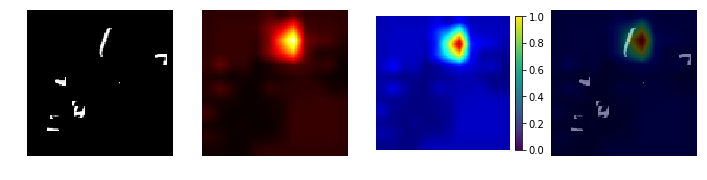

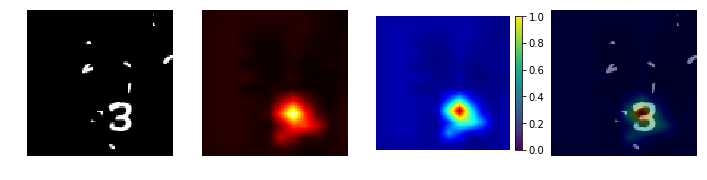

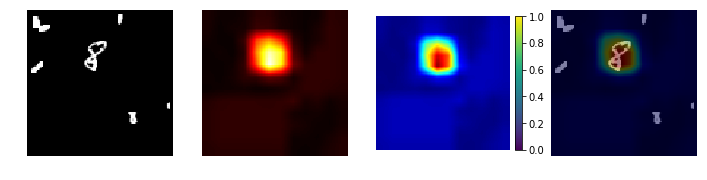

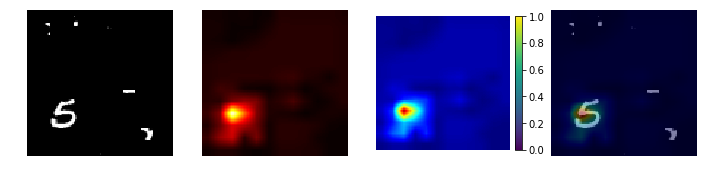

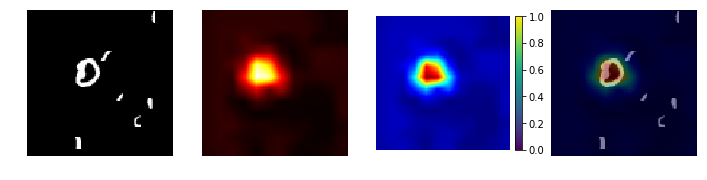

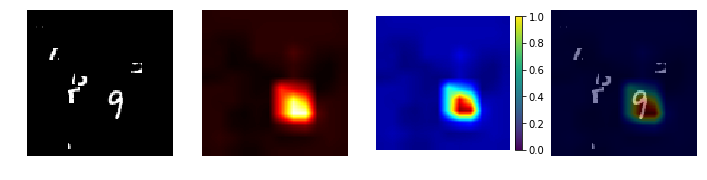

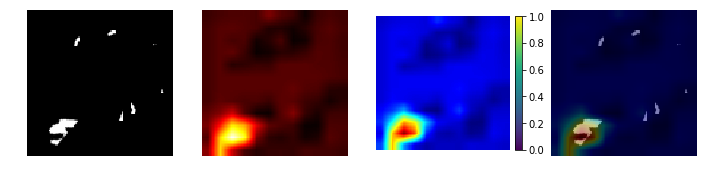

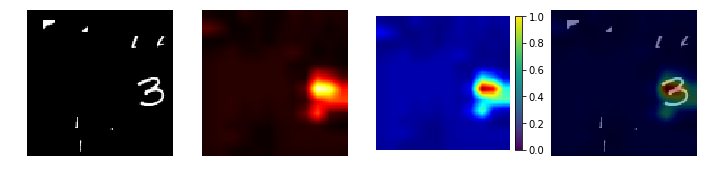

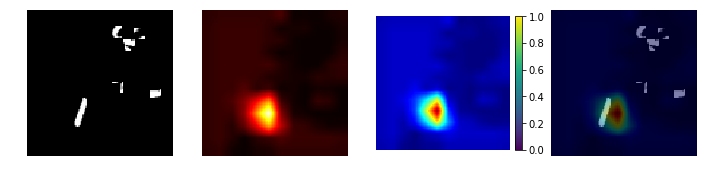

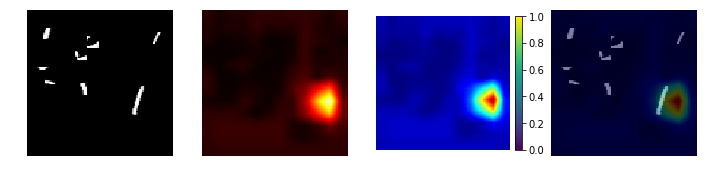

In [31]:
gradcam_pp = GradCAM_pp(model)

for i in range(10):
    X, y = valid_dataset[i]
    X_var = Variable(X.unsqueeze(0)).cuda()

    logits = gradcam_pp.forward(X_var)
    gradcam_pp.backward(logits)
    activ_map = gradcam_pp.activation_map()

    heatmap = Heatmap(X, activ_map)
    fig = heatmap.figure4()